## Intro bayesian modelling using pymc!

Author: Johan Thor with code proudly stolen from Simon Hedström



In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use("sodra.mplstyle")

import pymc as pm
import arviz as az


In [3]:
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)


In [4]:
# Below functions are written by Simon:


def delinearize(x):
    """Performs a linear regression and subtracts it from the signal."""
    k, m = np.polyfit(np.arange(len(x)), x, 1)
    return x - (k * np.arange(len(x)) + m)


def standardize(x):
    """Standardizes the signal using the sample mean and standard deviation."""
    std = np.std(x)
    if std == 0:
        std = 1
    return (x - np.mean(x)) / std


# Creating our initial problem

We generate the following signals $s_i$:
1. Random walk. Exponentially smoothed with a factor of $\frac{1}{30}$. Delinearized. Standardized. 
2. Sine wave with boolean logic $sin(t) > 0$. Standardized.
    
    
We construct our prediction target $y = standardize(s_1 + s_2)$.   
On top of that we also distort out target by adding noise $v \sim exp(\frac{1}{4})$

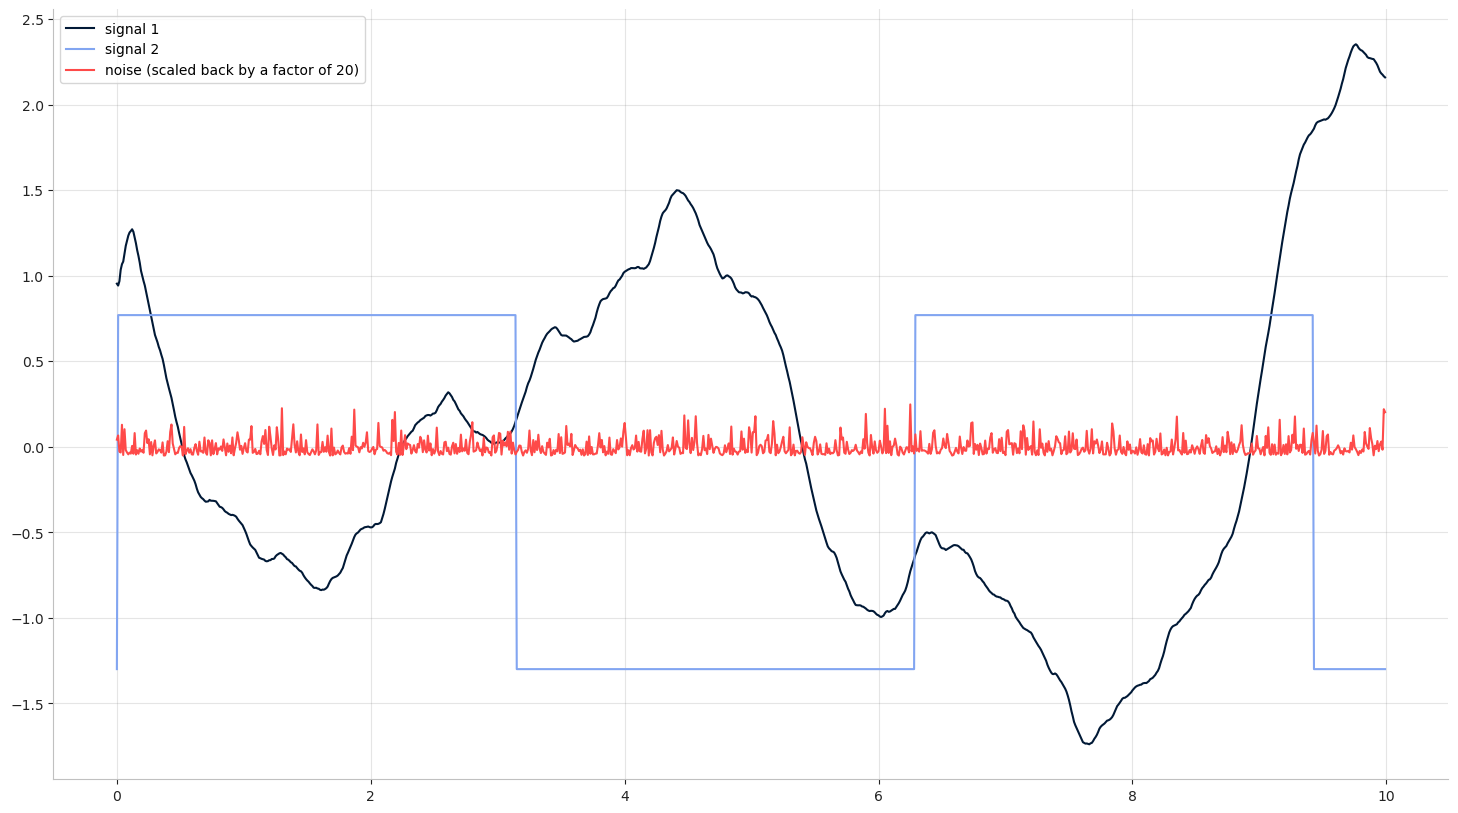

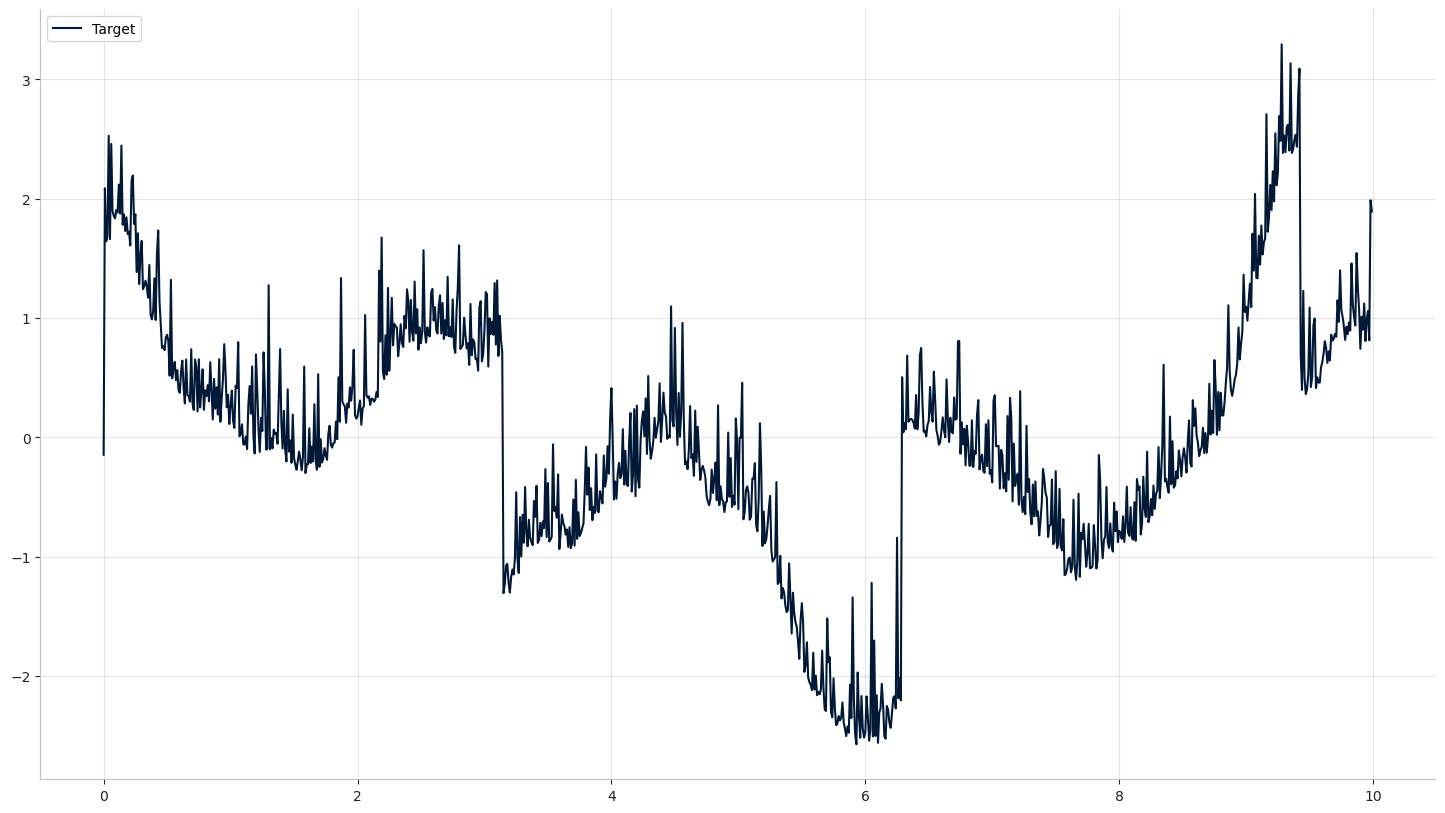

In [5]:
np.random.seed(RANDOM_SEED)


N = 1000
dt = 0.01
noise_factor = 1 / 4

# Time
t = dt * np.arange(N)

# Signal 1
signal1 = np.cumsum(np.random.randn(N))
signal1 = pd.Series(signal1).ewm(alpha=1 / 30).mean().values
signal1 = standardize(delinearize(signal1))

# Signal 2
signal2 = standardize(np.sin(t) > 0)

# Target
target = standardize(signal1 + signal2)

# Noise to target
noise = standardize(-np.log(np.random.rand(N)) - 1)
target += noise * noise_factor

# Plot data
fig, ax = plt.subplots()
ax.plot(t, signal1, label="signal 1")
ax.plot(t, signal2, label="signal 2")
ax.plot(t, noise / 20, label="noise (scaled back by a factor of 20)")
ax.legend()
plt.show()

# Plot target
fig, ax = plt.subplots()
ax.plot(t, target, label="Target")
ax.legend()
plt.show()


In [6]:
# Create X and Y
x = np.vstack([signal1, signal2]).T
y = target.reshape(-1, 1)

n_train = N // 3

# Get training set
t_train = t[:n_train]
x_train = x[:n_train]
y_train = y[:n_train]

# Get remaining set, predict
t_rest = t[n_train:]
x_rest = x[n_train:]
y_rest = y[n_train:]


In [7]:
# Let's make a model in pymc!

# 1. Start with the priors:
a_normal_distribution = pm.Normal.dist(mu=0, sigma=5)
a_half_normal_distribution = pm.HalfNormal.dist(sigma=5)
    

In [8]:
with pm.Model() as linear_model:
    beta = pm.Normal("beta", mu=0, sigma=5, shape=3)
    sigma = pm.HalfNormal("sigma", sigma=5)

    my = beta[0] + beta[1] * x_train + beta[2] * np.sin(x_train)  # + beta[3]*x_train

    ppl_target = pm.Normal("target", mu=my, sigma=sigma, observed=y_train)


In [10]:
with linear_model:
    linear_trace = pm.sample(1000, tune=2000, cores=4)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 8 seconds.


array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

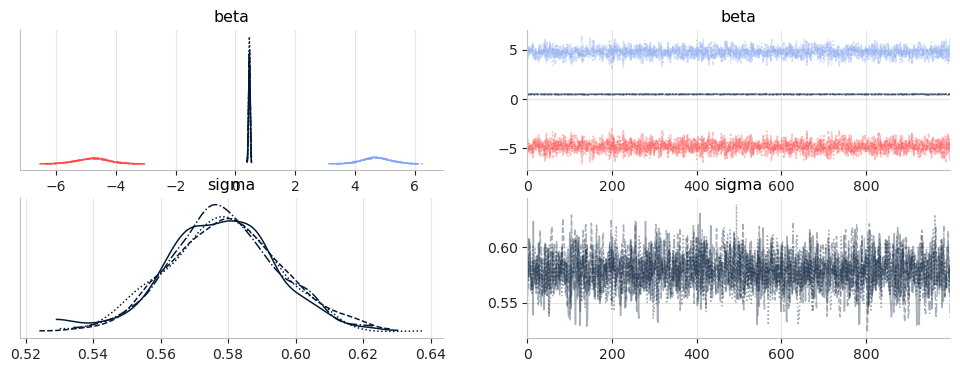

In [11]:
az.plot_trace(linear_trace)


In [12]:
az.summary(linear_trace, round_to=2)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.47,0.03,0.42,0.51,0.00,0.00,2587.82,2156.16,1.0
beta[1],4.72,0.46,3.88,5.60,0.01,0.01,1737.48,2325.43,1.0
beta[2],-4.78,0.52,-5.83,-3.86,0.01,0.01,1722.65,2281.18,1.0
sigma,0.58,0.02,0.55,0.61,0.00,0.00,2401.60,1772.18,1.0


In [13]:
X_pred = np.linspace(0, 10, 1000)


In [14]:
# chain, sample, [beta_0/beta_1]:
linear_trace.posterior.beta.shape


(4, 1000, 3)

In [15]:
linear_trace.posterior.sigma.shape


(4, 1000)

In [16]:
beta_0 = linear_trace.posterior.beta[1, :, 0]
beta_1 = linear_trace.posterior.beta[1, :, 1]
beta_2 = linear_trace.posterior.beta[1, :, 2]

sigma = linear_trace.posterior.sigma[1, :]


In [17]:
print(beta_0, beta_1, sigma)


<xarray.DataArray 'beta' (draw: 1000)>
array([0.44348498, 0.4238387 , 0.43941924, 0.43932552, 0.52817474,
       0.53131535, 0.4888233 , 0.46671758, 0.46278005, 0.47206177,
       0.44395641, 0.4398767 , 0.50203684, 0.50760933, 0.46798407,
       0.43459568, 0.40745343, 0.4383188 , 0.46438212, 0.46818527,
       0.47814639, 0.44021847, 0.48187438, 0.48788564, 0.46960986,
       0.5073262 , 0.50598033, 0.48929098, 0.43192976, 0.48792871,
       0.44568737, 0.47046107, 0.45990844, 0.4500102 , 0.45153871,
       0.4805943 , 0.48054569, 0.44559424, 0.45451446, 0.46159115,
       0.45007115, 0.46420218, 0.4752992 , 0.50308121, 0.43245452,
       0.43734379, 0.47340192, 0.47203111, 0.47759182, 0.47767473,
       0.45760707, 0.4600177 , 0.45072301, 0.45391146, 0.45391146,
       0.44337359, 0.47951182, 0.46438441, 0.45753143, 0.46337214,
       0.45412493, 0.45751315, 0.469562  , 0.46246501, 0.46246501,
       0.47679613, 0.42766886, 0.39256527, 0.44952907, 0.44538063,
       0.45039624, 0.48

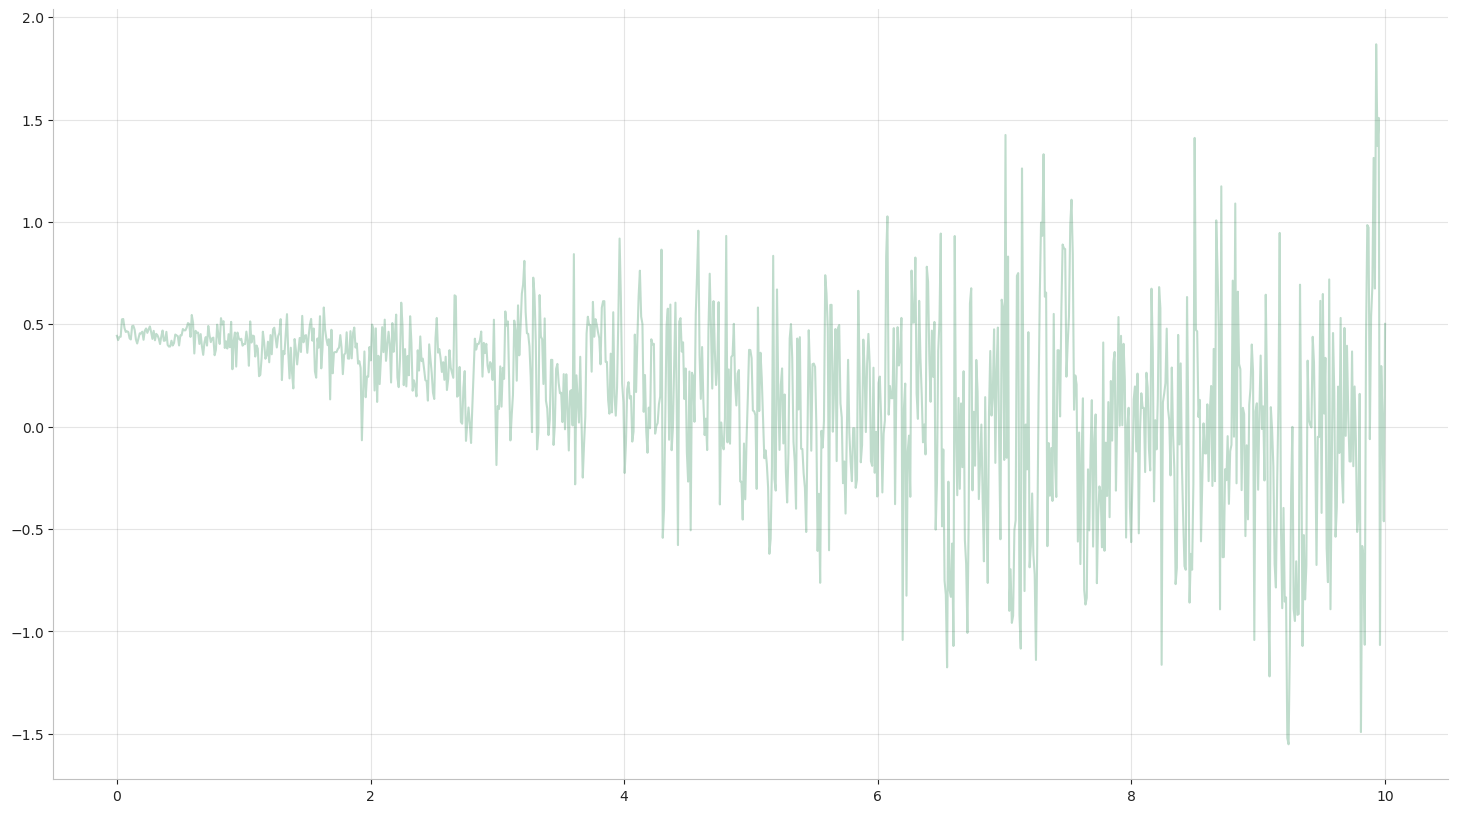

In [18]:
X_pred = np.linspace(0, 10, 1000)

# ax = salmon_data.plot.scatter(x='spawners', y='recruits', c='k', s=50)
# ax.set_ylim(0, None)
# for b0 in linear_trace.posterior["beta"][:2]:
plt.plot(
    X_pred, beta_0 + beta_1 * X_pred + beta_2 * X_pred, alpha=0.3, color="seagreen"
)
